In [1]:
import time
import datetime
import pandas as pd
import numpy as np
from numpy import mean, std
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.utils import resample
from sklearn.feature_selection import RFECV

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

from time import time

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.utils import shuffle

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
import catboost as cb

C:\Users\user\anaconda3\envs\py3-tf2\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Load data

In [3]:
df = pd.read_csv('rawdata_823.csv', encoding='latin1')
df.head()

,no,totalarea,sitearea,buildingarea,typicalfloorheight,totalheight,basement,groundlevel,parkinglot,type,...,type5,type6,type7,type8,type9,type10,type11,year,buildingcost,duration
0,1,1628.26,2253.0,461.65,3.6,16.86,1,4,17,3,...,0,0,0,0,0,0,0,2015,1985048000,360
1,2,1775.68,3182.0,726.15,3.9,19.17,0,3,35,3,...,0,0,0,0,0,0,0,2015,3124265785,225
2,4,4986.55,4923.0,820.37,4.2,32.50,1,6,77,3,...,0,0,0,0,0,0,0,2015,5191861411,450
3,5,2911.09,4577.1,793.10,3.6,15.70,1,4,71,3,...,0,0,0,0,0,0,0,2015,4750217393,300
4,6,906.12,1724.0,522.15,3.6,11.55,0,2,16,3,...,0,0,0,0,0,0,0,2015,924797000,180


In [4]:
unscaled_data = df.drop(['no','type', 'duration'], axis=1)
unscaled_inputs = df.drop(['no','type', 'buildingcost', 'duration'], axis=1)
unscaled_targets = df['buildingcost']
unscaled_data.describe()

,totalarea,sitearea,buildingarea,typicalfloorheight,totalheight,basement,groundlevel,parkinglot,type1,type2,...,type4,type5,type6,type7,type8,type9,type10,type11,year,buildingcost
count,823.000000,8.230000e+02,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,...,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,8.230000e+02
mean,8923.320462,5.594257e+04,3139.181363,4.197485,20.623166,0.880923,4.125152,105.139733,0.100851,0.179830,...,0.021871,0.065614,0.035237,0.035237,0.046173,0.234508,0.038882,0.014581,2017.781288,1.124788e+10
std,7485.673102,1.581240e+05,4012.058631,0.865314,8.565357,0.606464,1.955126,164.231407,0.301314,0.384279,...,0.146352,0.247756,0.184490,0.184490,0.209986,0.423948,0.193432,0.119940,1.864847,8.990614e+09
min,325.000000,1.748000e+00,26.480000,2.400000,3.900000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015.000000,2.510981e+08
25%,3658.685000,6.073100e+03,1312.750000,3.750000,15.650000,1.000000,3.000000,39.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2016.000000,5.170924e+09
50%,7202.920000,1.393179e+04,2317.090000,4.200000,19.200000,1.000000,4.000000,66.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2018.000000,9.682847e+09
75%,12114.580000,2.988280e+04,3791.605000,4.200000,22.975000,1.000000,5.000000,107.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2019.000000,1.450277e+10
max,66805.470000,1.510099e+06,48823.000000,12.000000,84.650000,4.000000,20.000000,1830.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2021.000000,8.651680e+10


In [5]:
unscaled_targets.describe()

count    8.230000e+02
mean     1.124788e+10
std      8.990614e+09
min      2.510981e+08
25%      5.170924e+09
50%      9.682847e+09
75%      1.450277e+10
max      8.651680e+10
Name: buildingcost, dtype: float64

## Features of Data

<Figure size 7500x3000 with 0 Axes>

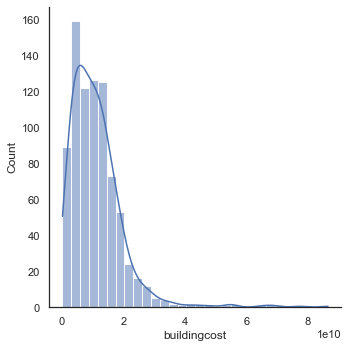

In [14]:
fig = plt.figure(figsize=(25,10),dpi=300)
sns.set(style = 'white')
sns.displot(data = unscaled_data, x = 'buildingcost', bins = 30, kde=True)
plt.savefig('Assembly Cost Distribution.pdf')

In [2]:
df = pd.read_csv('rawdata_801_CostScale.csv', encoding='latin1')

In [3]:
unscaled_data = df.drop(['no','type', 'duration'], axis=1)
unscaled_inputs = df.drop(['no','type', 'buildingcost', 'duration'], axis=1)
unscaled_targets = df['buildingcost']
unscaled_data.describe()

,totalarea,sitearea,buildingarea,typicalfloorheight,totalheight,basement,groundlevel,parkinglot,type1,type2,...,type4,type5,type6,type7,type8,type9,type10,type11,year,buildingcost
count,801.000000,8.010000e+02,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,8169.565318,5.215547e+04,2823.439765,4.192297,20.300856,0.868914,4.082397,96.471910,0.097378,0.177278,...,0.021223,0.067416,0.036205,0.036205,0.047441,0.239700,0.038702,0.009988,2017.785268,10250.865169
std,5498.545579,1.513706e+05,2960.825674,0.871045,7.985855,0.588681,1.882340,149.442195,0.296657,0.382143,...,0.144219,0.250897,0.186916,0.186916,0.212712,0.427167,0.193003,0.099499,1.859121,6212.361020
min,325.000000,1.748000e+00,26.480000,2.400000,3.900000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015.000000,251.000000
25%,3575.170000,5.940000e+03,1294.580000,3.700000,15.500000,1.000000,3.000000,38.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2016.000000,5036.000000
50%,7000.000000,1.349100e+04,2261.880000,4.200000,19.180000,1.000000,4.000000,65.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2018.000000,9483.000000
75%,11902.430000,2.815056e+04,3699.460000,4.200000,22.700000,1.000000,5.000000,107.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2019.000000,14210.000000
max,36699.070000,1.510099e+06,48823.000000,12.000000,70.000000,4.000000,20.000000,1830.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2021.000000,29859.000000


<Figure size 7500x3000 with 0 Axes>

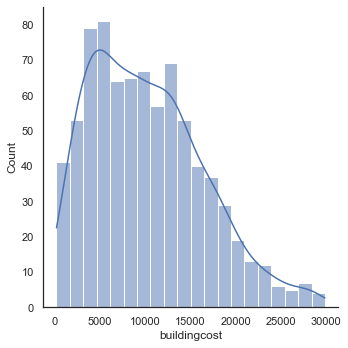

In [4]:
fig = plt.figure(figsize=(25,10),dpi=300)
sns.set(style = 'white')
sns.displot(data = unscaled_data, x = 'buildingcost', bins = 20, kde=True)
plt.savefig('Assembly Cost Distribution2.pdf')

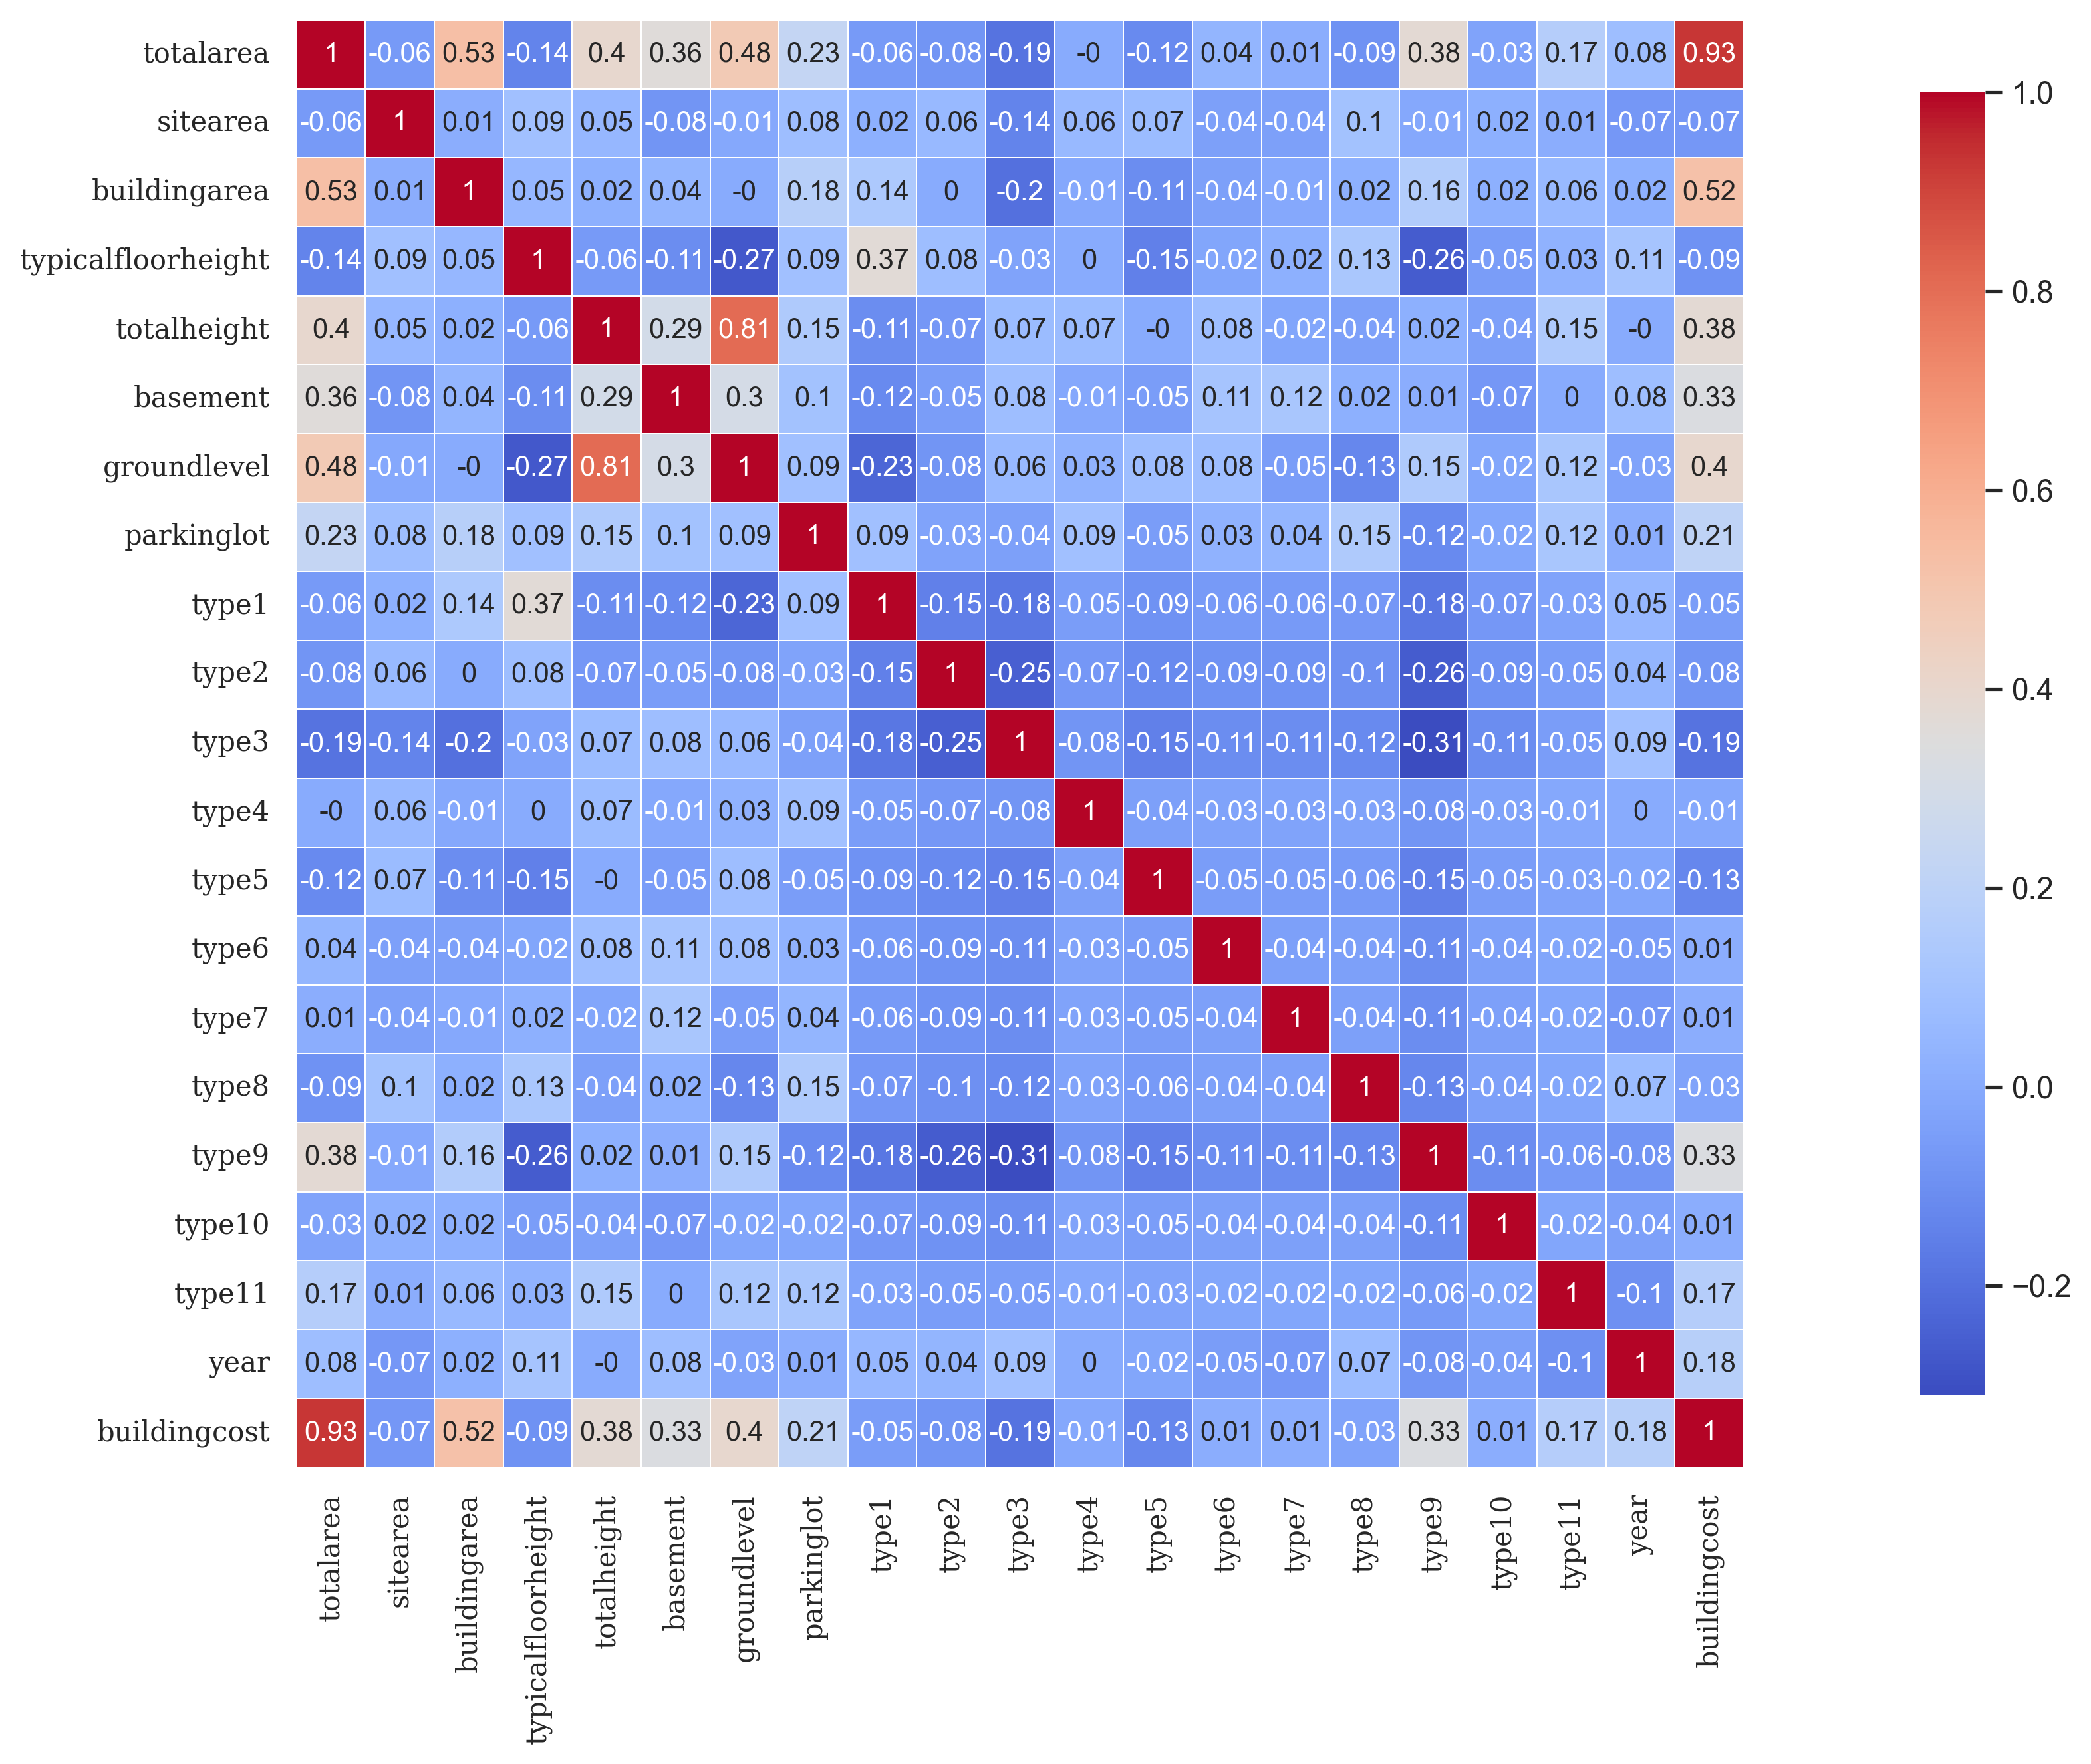

In [7]:
single_variate_corr_1 = unscaled_data.corr('pearson')
fig = plt.figure(figsize=(18,9),dpi=300)
#sns.set(font_scale=3.4)
sns.heatmap(np.round(single_variate_corr_1,2), vmax=1, square=True, linewidths=.1, annot=True, annot_kws={"size": 10}, 
            cbar_kws={"shrink": .9}, cmap='coolwarm')
plt.xticks(fontsize=10, fontname='Serif', rotation=90)
plt.yticks(fontsize=10, fontname='Serif')
plt.figaspect(1.)
plt.title('')
plt.tight_layout(pad=1.08)
fig.savefig('Correlation Heatmap.pdf', format='pdf', dpi=300, bbox_inches = 'tight')

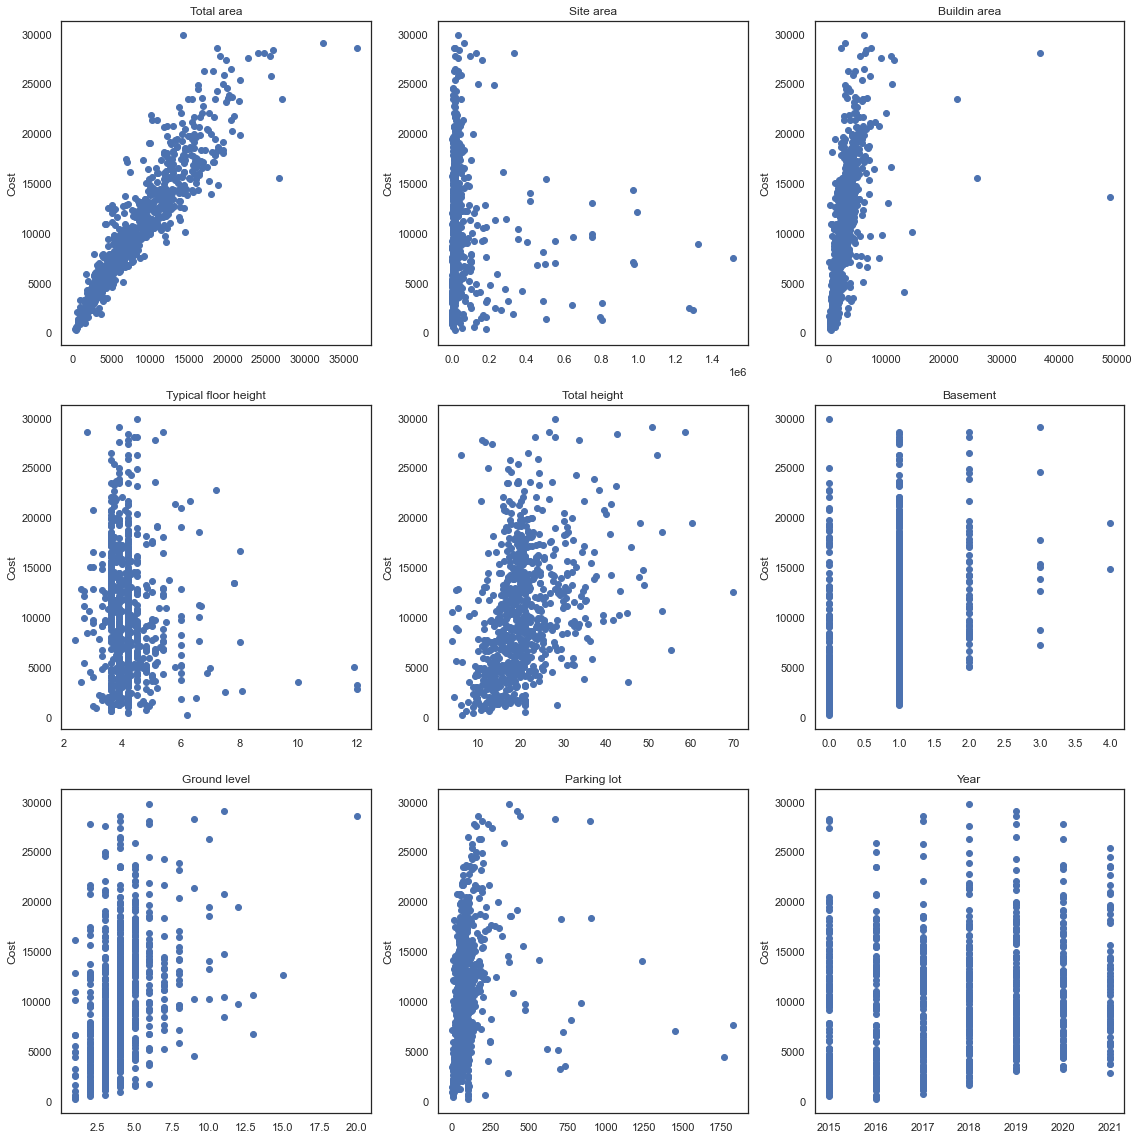

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,16))

axes[0, 0].plot(df['totalarea'],df['buildingcost'],'o')
axes[0, 0].set_ylabel("Cost")
axes[0, 0].set_title("Total area")

axes[0, 1].plot(df['sitearea'],df['buildingcost'],'o')
axes[0, 1].set_ylabel("Cost")
axes[0, 1].set_title("Site area")

axes[0, 2].plot(df['buildingarea'],df['buildingcost'],'o')
axes[0, 2].set_ylabel("Cost")
axes[0, 2].set_title("Buildin area");

axes[1, 0].plot(df['typicalfloorheight'],df['buildingcost'],'o')
axes[1, 0].set_ylabel("Cost")
axes[1, 0].set_title("Typical floor height");

axes[1, 1].plot(df['totalheight'],df['buildingcost'],'o')
axes[1, 1].set_ylabel("Cost")
axes[1, 1].set_title("Total height");

axes[1, 2].plot(df['basement'],df['buildingcost'],'o')
axes[1, 2].set_ylabel("Cost")
axes[1, 2].set_title("Basement");

axes[2, 0].plot(df['groundlevel'],df['buildingcost'],'o')
axes[2, 0].set_ylabel("Cost")
axes[2, 0].set_title("Ground level");

axes[2, 1].plot(df['parkinglot'],df['buildingcost'],'o')
axes[2, 1].set_ylabel("Cost")
axes[2, 1].set_title("Parking lot");

axes[2, 2].plot(df['year'],df['buildingcost'],'o')
axes[2, 2].set_ylabel("Cost")
axes[2, 2].set_title("Year");

plt.tight_layout();
fig.savefig('Correlation.pdf', format='pdf', dpi=300, bbox_inches = 'tight')

## Data preprocessing

In [4]:
Feature_Names = ['totalarea', 'sitearea', 'buildingarea', 'typicalfloorheight', 'totalheight', 'basement', 
                 'groundlevel', 'parkinglot', 
                 'type1', 'type2', 'type3', 'type4', 'type5', 'type6', 'type7', 'type8', 'type9', 'type10', 'type11',
                 'year']

X = unscaled_data[Feature_Names].to_numpy()
y = unscaled_data['buildingcost'].to_numpy()
#################################################################################################
# To test the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)
#################################################################################################
# Feature scaling required for neural network
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(y_train.reshape(-1, 1))
scaled_y_train = scaler.transform(y_train.reshape(-1, 1))
scaled_y_test = scaler.transform(y_test.reshape(-1, 1))
#################################################################################################
np.random.seed(7)
scoring_param = make_scorer(mean_squared_error,greater_is_better=False)
#################################################################################################

In [5]:
scaled_X_test, scaled_y_test

(array([[0.12942886, 0.00586271, 0.05685116, ..., 0.        , 0.        ,
         0.83333333],
        [0.07906672, 0.02642212, 0.05146913, ..., 0.        , 0.        ,
         0.83333333],
        [0.44112719, 0.0330858 , 0.29269336, ..., 1.        , 0.        ,
         0.        ],
        ...,
        [0.01228579, 0.02319044, 0.01310541, ..., 0.        , 0.        ,
         0.16666667],
        [0.05777053, 0.49552373, 0.05011577, ..., 0.        , 0.        ,
         0.5       ],
        [0.07709205, 0.00630116, 0.06496372, ..., 0.        , 0.        ,
         0.5       ]]),
 array([[ 0.17788125],
        [ 0.17991178],
        [ 0.69948187],
        [ 0.33458199],
        [ 0.60040611],
        [ 0.12795827],
        [ 0.11020865],
        [ 0.81938804],
        [ 0.35334687],
        [ 0.11073379],
        [ 0.11854082],
        [ 0.48435093],
        [ 0.2972973 ],
        [ 0.45781403],
        [ 0.04264109],
        [ 0.48407086],
        [ 0.14402745],
        [ 0.372391

## Neural Networks

In [12]:
n_features = scaled_X_train.shape[1]

ann = Sequential()
ann.add(Dense(40, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
ann.add(Dense(30, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
ann.add(Dense(1, activation='sigmoid'))

SGD_optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01)
Adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
Namam_optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
RMSprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, 
                                                momentum=0.0, epsilon=1e-07, centered=False)
ann.compile(optimizer=Adam_optimizer, loss='mean_squared_error')

t0 = time()

max_epochs =500
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 20)
history = ann.fit(scaled_X_train, scaled_y_train, epochs=max_epochs, batch_size=32, 
                    callbacks=[early_stopping],
                    validation_data = (scaled_X_test, scaled_y_test),
                    verbose=0, use_multiprocessing=True)

t1 = time()
Time_Taken = (t1-t0)/60
print("Time taken to train the model: %0.2f" % Time_Taken,"minutes")

#----------------------------------------------------------------------------------------------------------
#  min, max values of Cost in the training data
#----------------------------------------------------------------------------------------------------------
ymin = min(y_train)
ymax = max(y_train)

multiplier = ymax - ymin
#----------------------------------------------------------------------------------------------------------
# evaluate the model on training data
#----------------------------------------------------------------------------------------------------------
Y_hat = ann.predict(scaled_X_train)

Y_Train_Pred = (ymin + Y_hat * multiplier)

rmse = np.sqrt(mean_squared_error(y_train,Y_Train_Pred))
RSQ = r2_score(y_train,Y_Train_Pred)
MBE = np.mean(y_train - Y_Train_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")
#----------------------------------------------------------------------------------------------------------
# evaluate the model on testing data
#----------------------------------------------------------------------------------------------------------
Y_hat = ann.predict(scaled_X_test)

Y_Test_Pred = (ymin + Y_hat * multiplier)

rmse = np.sqrt(mean_squared_error(y_test,Y_Test_Pred))
RSQ = r2_score(y_test,Y_Test_Pred)
MBE = np.mean(y_test - Y_Test_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Time taken to train the model: 0.04 minutes
############ Model Accuracy on Daily Testing Data ############
RMSE: 1576.725
R-squared: 0.934
MBE: 212.667
########################################
 
############ Model Accuracy on Daily Testing Data ############
RMSE: 2213.831
R-squared: 0.879
MBE: 301.308
########################################
 


### Visualizing the history object of model

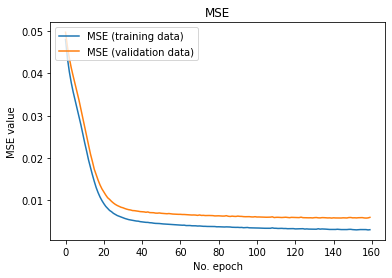

In [13]:
plt.plot(history.history['loss'], label = 'MSE (training data)')
plt.plot(history.history['val_loss'], label = 'MSE (validation data)')
plt.title('MSE')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc = 'upper left')
plt.show()

## Linear Regression

In [15]:
t0 = time()

#lin_reg = LinearRegression(normalize=True).fit(X_train, y_train)
lin_reg = LinearRegression().fit(scaled_X_train, scaled_y_train)

t1 = time()
Time_Taken = (t1-t0)
print("Time taken to train the model: %0.2f" % Time_Taken,"seconds")

Y_hat = lin_reg.predict(scaled_X_train)
Y_Train_Pred = (ymin + Y_hat * multiplier)
rmse = np.sqrt(mean_squared_error(y_train.ravel(),Y_Train_Pred))
RSQ = r2_score(y_train.ravel(),Y_Train_Pred)
MBE = np.mean(y_train.ravel() - Y_Train_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Training Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Y_hat = lin_reg.predict(scaled_X_test)

Y_Test_Pred = (ymin + Y_hat * multiplier)

rmse = np.sqrt(mean_squared_error(y_test.ravel(),Y_Test_Pred))
RSQ = r2_score(y_test.ravel(),Y_Test_Pred)
MBE = np.mean(y_test.ravel() - Y_Test_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")
################################################################
################################################################
print("############ Model Coefficients ############")
print(np.round((lin_reg.coef_),2))

Time taken to train the model: 0.00 seconds
############ Model Accuracy on Daily Training Data ############
RMSE: 1964.987
R-squared: 0.897
MBE: -0.000
########################################
 
############ Model Accuracy on Daily Testing Data ############
RMSE: 2456.559
R-squared: 0.851
MBE: -161.762
########################################
 
############ Model Coefficients ############
[[ 1.13 -0.01  0.1   0.01  0.17  0.03 -0.2  -0.03 -0.02 -0.01 -0.01 -0.04
  -0.   -0.02 -0.01  0.02 -0.    0.04  0.05  0.07]]


## Random Forest

In [53]:
t0 = time()

p_grid = dict(n_estimators = [int(i) for i in np.linspace(100,2000,num=20)],
    max_depth = [int(i) for i in np.linspace(1,10,num=10)],
  min_samples_leaf = [int(i) for i in np.linspace(1,10,num=10)])

rf = GridSearchCV(estimator = RandomForestRegressor(random_state=7), param_grid = p_grid, 
                     scoring = scoring_param, cv = 3, verbose=1, n_jobs=-1)

rf.fit(scaled_X_train, scaled_y_train.ravel())

t1 = time()
Time_Taken = (t1-t0)
print("Time taken to train the model: %0.2f" % Time_Taken,"seconds")
print("Best RF Estimators: %0.3f" % rf.best_params_.get('n_estimators'))
print("Best RF Max Depth: %0.3f" % rf.best_params_.get('max_depth'))
print("Best RF Min Samples in Leaf: %0.3f" % rf.best_params_.get('min_samples_leaf'))

Y_hat = rf.predict(scaled_X_train)
Y_Train_Pred = (ymin + Y_hat * multiplier)
rmse = np.sqrt(mean_squared_error(y_train.ravel(),Y_Train_Pred))
RSQ = r2_score(y_train.ravel(),Y_Train_Pred)
MBE = np.mean(y_train.ravel() - Y_Train_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Training Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Y_hat = rf.predict(scaled_X_test)
Y_Test_Pred = (ymin + Y_hat * multiplier)
rmse = np.sqrt(mean_squared_error(y_test.ravel(),Y_Test_Pred))
RSQ = r2_score(y_test.ravel(),Y_Test_Pred)
MBE = np.mean(y_test.ravel() - Y_Test_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Fitting 3 folds for each of 2000 candidates, totalling 6000 fits
Time taken to train the model: 2680.84 seconds
Best RF Estimators: 100.000
Best RF Max Depth: 10.000
Best RF Min Samples in Leaf: 2.000
############ Model Accuracy on Daily Training Data ############
RMSE: 975.378
R-squared: 0.975
MBE: -0.759
########################################
 
############ Model Accuracy on Daily Testing Data ############
RMSE: 2236.130
R-squared: 0.877
MBE: -74.801
########################################
 


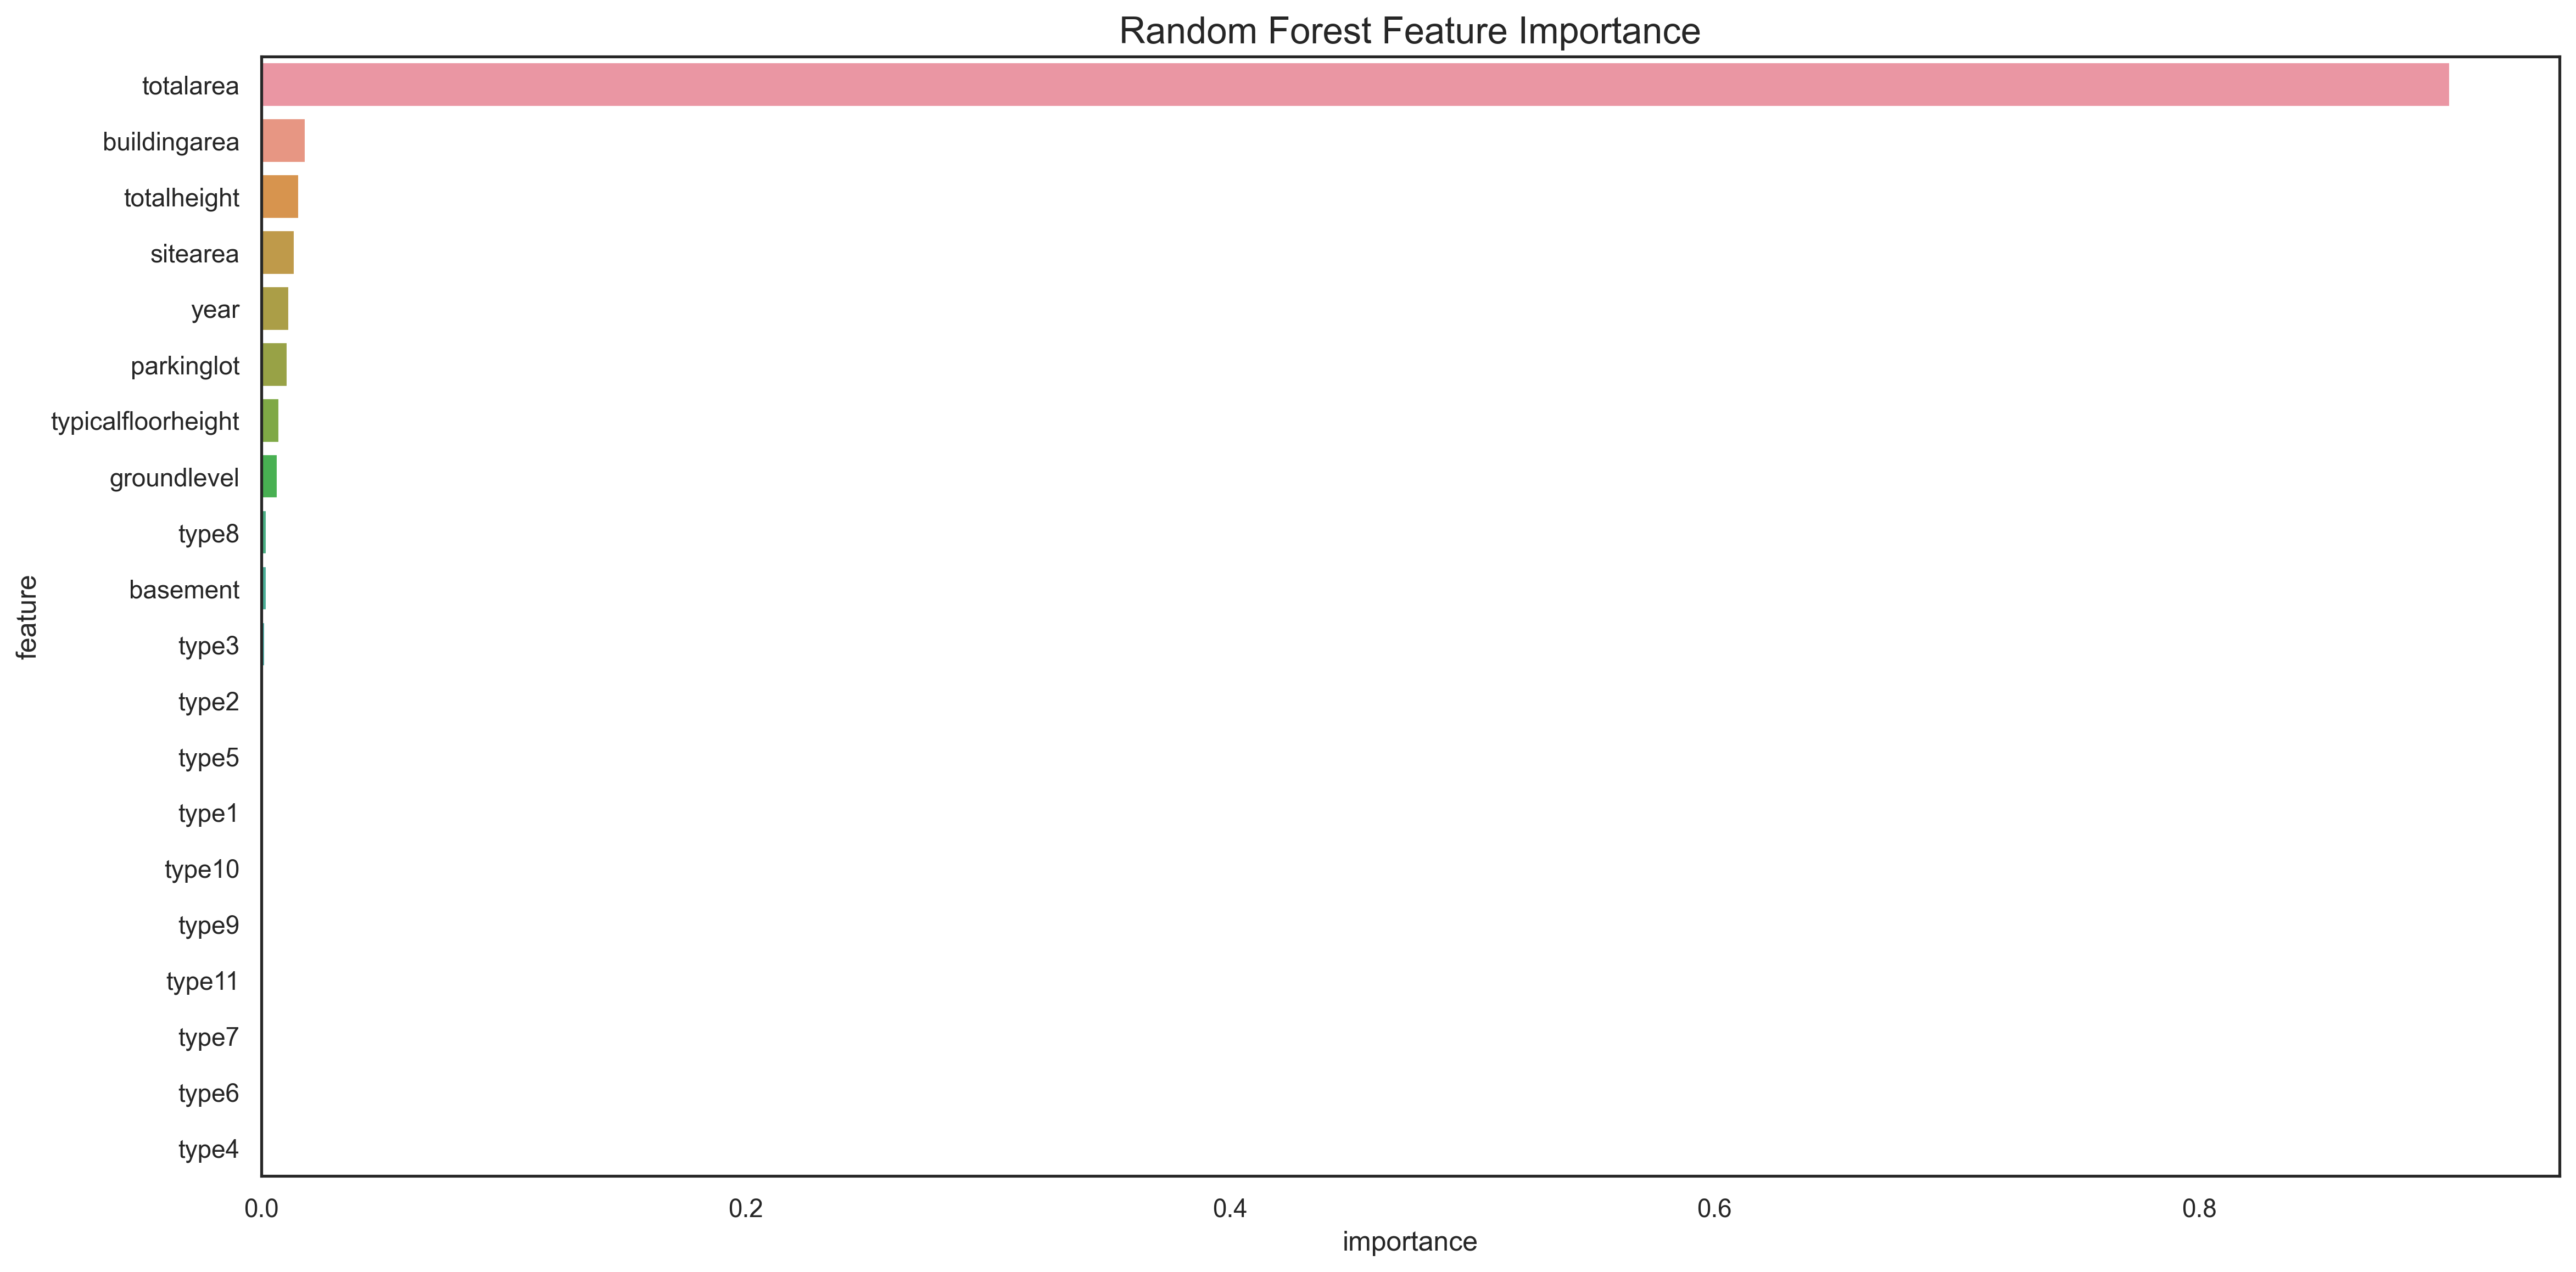

In [17]:
forest_reg = RandomForestRegressor(n_estimators=100)
forest_reg.fit(scaled_X_train, scaled_y_train.ravel())

feature_imp_df = pd.DataFrame()
feature_imp_df["feature"] = Feature_Names
feature_imp_df["importance"] = forest_reg.feature_importances_
feature_imp_df.sort_values(by='importance', ascending=False, inplace=True)
feature_imp_df.reset_index(drop=True, inplace=True)
feature_imp_df

plt.figure(figsize=(18,9),dpi=300)

sns.barplot(x='importance', y='feature', data=feature_imp_df)
plt.title("Random Forest Feature Importance", fontsize=16)

plt.show()

## XGBoost

In [54]:
t0 = time()

p_grid = dict(n_estimators = [int(i) for i in np.linspace(100,2000,num=20)],
    max_depth = [int(i) for i in np.linspace(1,10,num=10)],
  learning_rate = np.linspace(0.001,0.1,num=10))

xgb = GridSearchCV(estimator = XGBRegressor(random_state=7), param_grid = p_grid, 
                     scoring = scoring_param, cv = 3, verbose=1, n_jobs=-1)

xgb.fit(scaled_X_train, scaled_y_train.ravel())

t1 = time()
Time_Taken = (t1-t0)
print("Time taken to train the model: %0.2f" % Time_Taken,"seconds")
print("Best XGB Estimators: %0.3f" % xgb.best_params_.get('n_estimators'))
print("Best XGB Max Depth: %0.3f" % xgb.best_params_.get('max_depth'))
print("Best XGB Learning Rate: %0.3f" % xgb.best_params_.get('learning_rate'))

Y_hat = xgb.predict(scaled_X_train)
Y_Train_Pred = (ymin + Y_hat * multiplier)

rmse = np.sqrt(mean_squared_error(y_train.ravel(),Y_Train_Pred))
RSQ = r2_score(y_train.ravel(),Y_Train_Pred)
MBE = np.mean(y_train.ravel() - Y_Train_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Training Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Y_hat = xgb.predict(scaled_X_test)
Y_Test_Pred = (ymin + Y_hat * multiplier)

rmse = np.sqrt(mean_squared_error(y_test.ravel(),Y_Test_Pred))
RSQ = r2_score(y_test.ravel(),Y_Test_Pred)
MBE = np.mean(y_test.ravel() - Y_Test_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Fitting 3 folds for each of 2000 candidates, totalling 6000 fits
Time taken to train the model: 2008.37 seconds
Best XGB Estimators: 200.000
Best XGB Max Depth: 2.000
Best XGB Learning Rate: 0.056
############ Model Accuracy on Daily Training Data ############
RMSE: 1507.061
R-squared: 0.940
MBE: 0.025
########################################
 
############ Model Accuracy on Daily Testing Data ############
RMSE: 2148.135
R-squared: 0.886
MBE: -104.949
########################################
 


## Light GBM

In [82]:
t0 = time()

p_grid = dict(n_estimators = [int(i) for i in np.linspace(100,2000,num=20)],
    max_depth = [int(i) for i in np.linspace(1,10,num=10)],
  learning_rate = np.linspace(0.001,0.1,num=10))

lgb = GridSearchCV(estimator = LGBMRegressor(random_state=7), param_grid = p_grid, 
                     scoring = scoring_param, cv = 3, verbose=1, n_jobs=-1)

lgb.fit(scaled_X_train, scaled_y_train.ravel())

t1 = time()
Time_Taken = (t1-t0)
print("Time taken to train the model: %0.2f" % Time_Taken,"seconds")
print("Best LGB Estimators: %0.3f" % lgb.best_params_.get('n_estimators'))
print("Best LGB Max Depth: %0.3f" % lgb.best_params_.get('max_depth'))
print("Best LGB Learning Rate: %0.3f" % lgb.best_params_.get('learning_rate'))

Y_hat = lgb.predict(scaled_X_train)
Y_Train_Pred = (ymin + Y_hat * multiplier)

rmse = np.sqrt(mean_squared_error(y_train.ravel(),Y_Train_Pred))
RSQ = r2_score(y_train.ravel(),Y_Train_Pred)
MBE = np.mean(y_train.ravel() - Y_Train_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Training Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Y_hat = lgb.predict(scaled_X_test)
Y_Test_Pred = (ymin + Y_hat * multiplier)

rmse = np.sqrt(mean_squared_error(y_test.ravel(),Y_Test_Pred))
RSQ = r2_score(y_test.ravel(),Y_Test_Pred)
MBE = np.mean(y_test.ravel() - Y_Test_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Fitting 3 folds for each of 2000 candidates, totalling 6000 fits
Time taken to train the model: 279.62 seconds
Best LGB Estimators: 600.000
Best LGB Max Depth: 2.000
Best LGB Learning Rate: 0.012
############ Model Accuracy on Daily Training Data ############
RMSE: 1680.154
R-squared: 0.925
MBE: -0.000
########################################
 
############ Model Accuracy on Daily Testing Data ############
RMSE: 2193.934
R-squared: 0.881
MBE: -126.412
########################################
 


## SVM

In [83]:
t0 = time()

param_grid = {'C': [1, 10, 30, 50, 100, 200, 250, 300, 400, 500, 1000],
             'kernel': ['rbf'],
             'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1],
             'degree': [2, 3, 4],
             'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, ]}
svr = SVR()
grid = GridSearchCV(estimator=svr, 
                    param_grid = param_grid,
                    cv=3,
                    n_jobs=-1,
                    verbose = 2)
grid.fit(scaled_X_train, scaled_y_train.ravel())

t1 = time()
Time_Taken = (t1-t0)
print("Time taken to train the model: %0.2f" % Time_Taken,"seconds")
print("Best C value: %0.3f" % grid.best_params_.get('C'))
print("Best degree: %0.0f" % grid.best_params_.get('degree'))
print("Best epsilon: %0.3f" % grid.best_params_.get('epsilon'))
print("Best gamma: %0.3f" % grid.best_params_.get('gamma'))

Y_hat = grid.predict(scaled_X_train)
Y_Train_Pred = (ymin + Y_hat * multiplier)

rmse = np.sqrt(mean_squared_error(y_train.ravel(),Y_Train_Pred))
RSQ = r2_score(y_train.ravel(),Y_Train_Pred)
MBE = np.mean(y_train.ravel() - Y_Train_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Training Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Y_hat = grid.predict(scaled_X_test)
Y_Test_Pred = (ymin + Y_hat * multiplier)
rmse = np.sqrt(mean_squared_error(y_test.ravel(),Y_Test_Pred))
RSQ = r2_score(y_test.ravel(),Y_Test_Pred)
MBE = np.mean(y_test.ravel() - Y_Test_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Fitting 3 folds for each of 1848 candidates, totalling 5544 fits
Time taken to train the model: 76.24 seconds
Best C value: 400.000
Best degree: 2
Best epsilon: 0.005
Best gamma: 0.010
############ Model Accuracy on Daily Training Data ############
RMSE: 1812.210
R-squared: 0.913
MBE: 163.812
########################################
 
############ Model Accuracy on Daily Testing Data ############
RMSE: 2259.544
R-squared: 0.874
MBE: 98.003
########################################
 


## Bagging Tree Regressor

In [29]:
bagging = BaggingRegressor(DecisionTreeRegressor())
bagging.fit(scaled_X_train, scaled_y_train.ravel())

t1 = time()
Time_Taken = (t1-t0)
print("Time taken to train the model: %0.2f" % Time_Taken,"seconds")

Y_hat = bagging.predict(scaled_X_train)
Y_Train_Pred = (ymin + Y_hat * multiplier)
rmse = np.sqrt(mean_squared_error(y_train.ravel(),Y_Train_Pred))
RSQ = r2_score(y_train.ravel(),Y_Train_Pred)
MBE = np.mean(y_train.ravel() - Y_Train_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Training Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Y_hat = bagging.predict(scaled_X_test)
Y_Test_Predd = (ymin + Y_hat * multiplier)
rmse = np.sqrt(mean_squared_error(y_test.ravel(),Y_Test_Pred))
RSQ = r2_score(y_test.ravel(),Y_Test_Pred)
MBE = np.mean(y_test.ravel() - Y_Test_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Time taken to train the model: 993.44 seconds
############ Model Accuracy on Daily Training Data ############
RMSE: 868.326
R-squared: 0.980
MBE: 20.241
########################################
 
############ Model Accuracy on Daily Testing Data ############
RMSE: 2286.217
R-squared: 0.871
MBE: -474.695
########################################
 


## Adaboost 

In [28]:
ada = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=4), n_estimators=100, random_state=42
)

ada.fit(scaled_X_train, scaled_y_train.ravel())
#print ("score for bagged trees:", model.score(X_train, y_train.ravel())

t1 = time()
Time_Taken = (t1-t0)
print("Time taken to train the model: %0.2f" % Time_Taken,"seconds")

Y_hat = ada.predict(scaled_X_train)
Y_Train_Pred = (ymin + Y_hat * multiplier)
rmse = np.sqrt(mean_squared_error(y_train.ravel(),Y_Train_Pred))
RSQ = r2_score(y_train.ravel(),Y_Train_Pred)
MBE = np.mean(y_train.ravel() - Y_Train_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Training Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Y_hat = ada.predict(scaled_X_test)
Y_Test_Pred = (ymin + Y_hat * multiplier)
rmse = np.sqrt(mean_squared_error(y_test.ravel(),Y_Test_Pred))
RSQ = r2_score(y_test.ravel(),Y_Test_Pred)
MBE = np.mean(y_test.ravel() - Y_Test_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Time taken to train the model: 928.13 seconds
############ Model Accuracy on Daily Training Data ############
RMSE: 1523.253
R-squared: 0.938
MBE: -395.856
########################################
 
############ Model Accuracy on Daily Testing Data ############
RMSE: 2286.217
R-squared: 0.871
MBE: -474.695
########################################
 


## CatBoost regressor 

In [50]:
train_dataset = cb.Pool(scaled_X_train, scaled_y_train.ravel()) 
test_dataset = cb.Pool(scaled_X_test, scaled_y_test)
#build model
cat_model = cb.CatBoostRegressor(loss_function = 'RMSE') 
                                 
grid = {'iterations': [200, 250, 300],
        'learning_rate': [0.01, 0.03, 0.05, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
#cat_model.grid_search(grid, train_dataset, verbose = 0)                     

cat_grid = GridSearchCV(estimator = cat_model, param_grid = grid, 
                     scoring = scoring_param, cv = 3, verbose=1, n_jobs=-1)

cat_grid.fit(scaled_X_train, scaled_y_train.ravel())

t1 = time()
Time_Taken = (t1-t0) 
print("Time taken to train the model: %0.2f" % Time_Taken,"seconds")
print("Best iterations value: %0.0f" % cat_grid.best_params_.get('iterations'))
print("Best learning_rate: %0.3f" % cat_grid.best_params_.get('learning_rate'))
print("Best depth: %0.3f" % cat_grid.best_params_.get('depth'))
print("Best l2_leaf_reg: %0.3f" % cat_grid.best_params_.get('l2_leaf_reg'))


Y_hat = cat_grid.predict(scaled_X_train)
Y_Train_Pred = (ymin + Y_hat * multiplier)
                                 
rmse = np.sqrt(mean_squared_error(y_train.ravel(),Y_Train_Pred))
RSQ = r2_score(y_train.ravel(),Y_Train_Pred)
MBE = np.mean(y_train.ravel() - Y_Train_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Training Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Y_hat = cat_grid.predict(scaled_X_test)
Y_Test_Pred = (ymin + Y_hat * multiplier)
                                 
rmse = np.sqrt(mean_squared_error(y_test.ravel(),Y_Test_Pred))
RSQ = r2_score(y_test.ravel(),Y_Test_Pred)
MBE = np.mean(y_test.ravel() - Y_Test_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Fitting 3 folds for each of 192 candidates, totalling 576 fits
0:	learn: 0.2068355	total: 860us	remaining: 257ms
1:	learn: 0.1997951	total: 1.58ms	remaining: 236ms
2:	learn: 0.1928859	total: 2.17ms	remaining: 215ms
3:	learn: 0.1860334	total: 2.93ms	remaining: 217ms
4:	learn: 0.1790026	total: 3.58ms	remaining: 211ms
5:	learn: 0.1730645	total: 4.17ms	remaining: 204ms
6:	learn: 0.1675147	total: 4.79ms	remaining: 200ms
7:	learn: 0.1617359	total: 5.36ms	remaining: 195ms
8:	learn: 0.1564914	total: 5.98ms	remaining: 193ms
9:	learn: 0.1512263	total: 6.51ms	remaining: 189ms
10:	learn: 0.1463196	total: 7.1ms	remaining: 187ms
11:	learn: 0.1418700	total: 7.71ms	remaining: 185ms
12:	learn: 0.1374574	total: 8.27ms	remaining: 183ms
13:	learn: 0.1338938	total: 8.85ms	remaining: 181ms
14:	learn: 0.1296333	total: 9.43ms	remaining: 179ms
15:	learn: 0.1262608	total: 10.1ms	remaining: 180ms
16:	learn: 0.1228888	total: 10.9ms	remaining: 181ms
17:	learn: 0.1195554	total: 11.6ms	remaining: 182ms
18:	learn: 0.

267:	learn: 0.0431668	total: 156ms	remaining: 18.7ms
268:	learn: 0.0430958	total: 157ms	remaining: 18.1ms
269:	learn: 0.0430799	total: 158ms	remaining: 17.5ms
270:	learn: 0.0429591	total: 158ms	remaining: 16.9ms
271:	learn: 0.0428030	total: 159ms	remaining: 16.4ms
272:	learn: 0.0427358	total: 159ms	remaining: 15.8ms
273:	learn: 0.0426375	total: 160ms	remaining: 15.2ms
274:	learn: 0.0425977	total: 161ms	remaining: 14.6ms
275:	learn: 0.0425502	total: 161ms	remaining: 14ms
276:	learn: 0.0425250	total: 162ms	remaining: 13.4ms
277:	learn: 0.0424981	total: 162ms	remaining: 12.9ms
278:	learn: 0.0423744	total: 163ms	remaining: 12.3ms
279:	learn: 0.0423418	total: 164ms	remaining: 11.7ms
280:	learn: 0.0422685	total: 165ms	remaining: 11.1ms
281:	learn: 0.0422125	total: 165ms	remaining: 10.5ms
282:	learn: 0.0421066	total: 166ms	remaining: 9.96ms
283:	learn: 0.0420191	total: 167ms	remaining: 9.38ms
284:	learn: 0.0419341	total: 167ms	remaining: 8.8ms
285:	learn: 0.0418187	total: 168ms	remaining: 8.2

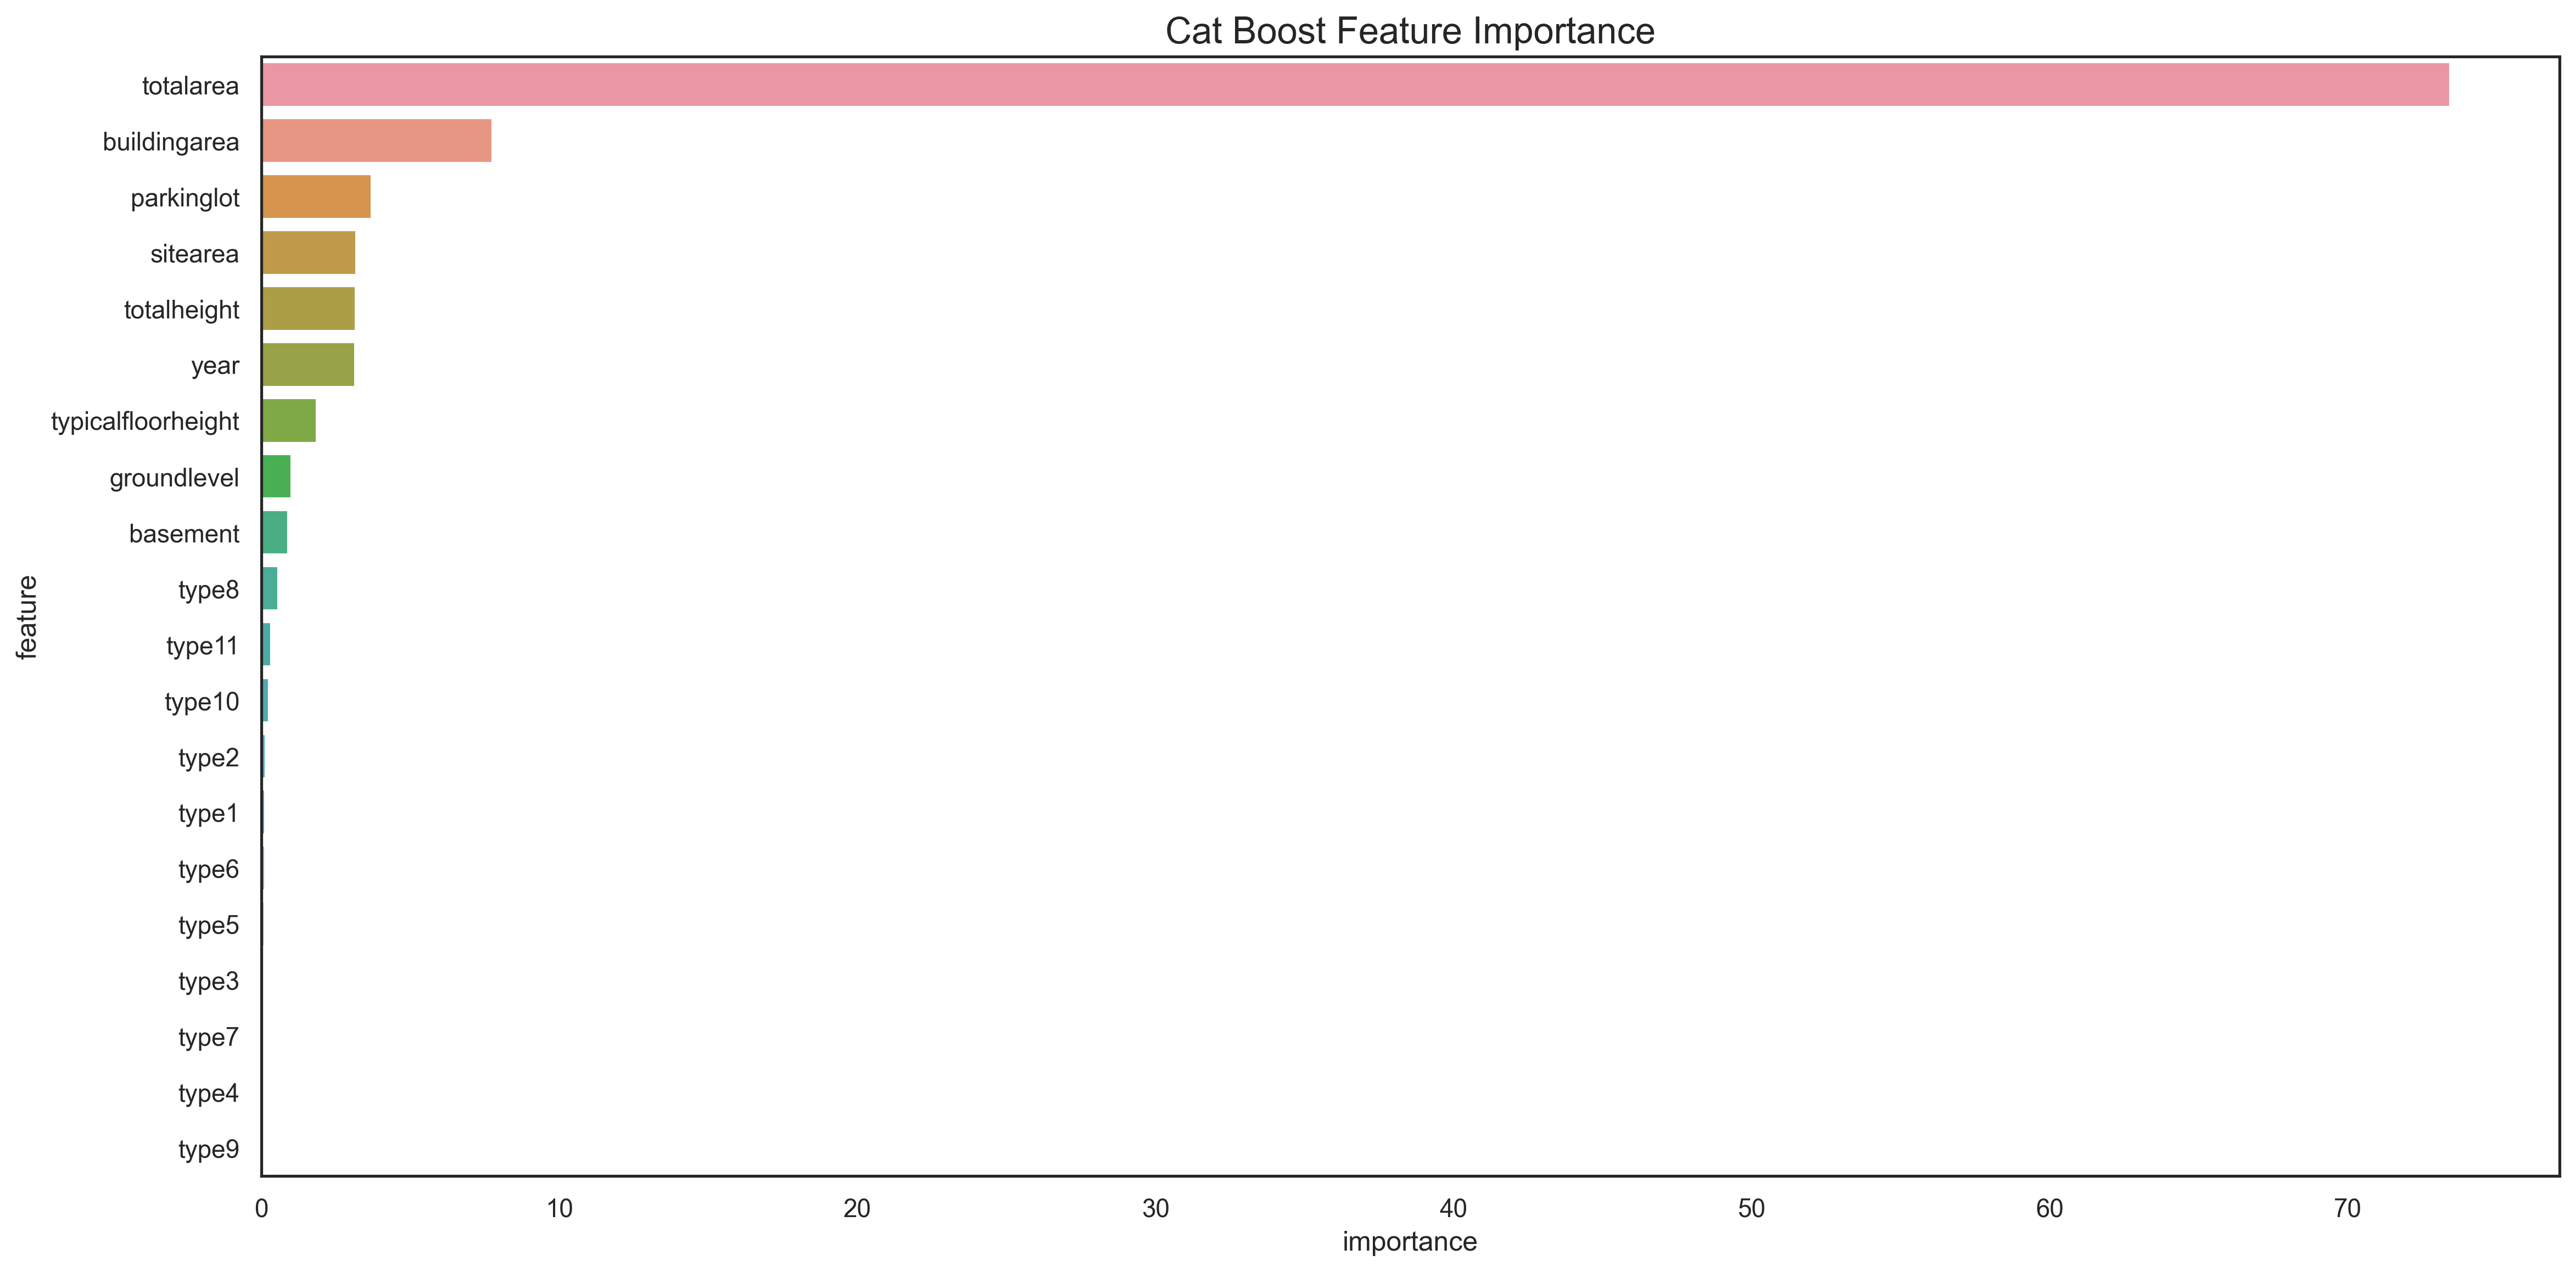

In [47]:
cat_feature_imp_df = pd.DataFrame()
cat_feature_imp_df["feature"] = Feature_Names
cat_feature_imp_df["importance"] = cat_model.feature_importances_
cat_feature_imp_df.sort_values(by='importance', ascending=False, inplace=True)
cat_feature_imp_df.reset_index(drop=True, inplace=True)
cat_feature_imp_df

plt.figure(figsize=(18,9),dpi=300)

sns.barplot(x='importance', y='feature', data=cat_feature_imp_df)
plt.title("Cat Boost Feature Importance", fontsize=16)

plt.show()

## Stacking Ensemble Method

In [90]:
# define the base models
#Keras Model
def build_nn():
    model= Sequential()
    model.add(Dense(30, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
    model.add(Dense(30, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam_optimizer, loss='mean_squared_error')
    return model

keras_reg = tf.keras.wrappers.scikit_learn.KerasRegressor(build_nn, epochs=200, batch_size=32,verbose=False)
keras_reg._estimator_type = "regressor"

bagging_reg = BaggingRegressor(DecisionTreeRegressor())
ada_reg = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=4), n_estimators=100, random_state=42
)
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=9, min_samples_leaf=2)
xgb_reg = XGBRegressor(n_estimators =100, max_depth=2, learning_rate = 0.067)
lgb_reg = LGBMRegressor(n_estimators = 100 , max_depth = 3 , learning_rate = 0.056)
svr_reg = SVR(C = 400 ,  degree = 2 , epsilon = 0.005, gamma = 0.01)
cat_reg = cb.CatBoostRegressor(iterations = 300 , learning_rate = 0.05, 
                               depth = 4, l2_leaf_reg = 0.500,verbose=False )

level0 = list()
#level0.append(('MLR', lin_reg))
#level0.append(('RF', rf_reg))
#level0.append(('BDT', bagging_reg))
level0.append(('XRB', xgb_reg))
#level0.append(('SVR', svr_reg))
level0.append(('LGB', lgb_reg))
#level0.append(('ADA', ada_reg))
level0.append(('CAT', cat_reg))
level0.append(('ANN', keras_reg))
#level0.append(('knn', KNeighborsRegressor()))
      
# define meta lelevel1 = lin_regarner model
level1 = svr_reg
# define the stacking ensemble
SRmodel = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
SRmodel.fit(scaled_X_train, scaled_y_train.ravel())

Y_hat = SRmodel.predict(scaled_X_train)
Y_Train_Pred = (ymin + Y_hat * multiplier)

rmse = np.sqrt(mean_squared_error(y_train.ravel(),Y_Train_Pred))
RSQ = r2_score(y_train.ravel(),Y_Train_Pred)
MBE = np.mean(y_train.ravel() - Y_Train_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Training Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Y_hat = SRmodel.predict(scaled_X_test)
Y_Test_Pred = (ymin + Y_hat * multiplier)
rmse = np.sqrt(mean_squared_error(y_test.ravel(),Y_Test_Pred))
RSQ = r2_score(y_test.ravel(),Y_Test_Pred)
MBE = np.mean(y_test.ravel() - Y_Test_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

############ Model Accuracy on Daily Training Data ############
RMSE: 1370.275
R-squared: 0.950
MBE: 219.977
########################################
 
############ Model Accuracy on Daily Testing Data ############
RMSE: 2076.730
R-squared: 0.894
MBE: 155.267
########################################
 
